# Tutorial: Find an Inspiral

We try to find an inspiral from the GW data. This code is taken from the tutorial located at [Tutorial: Find an Inspiral](https://gwosc.org/tutorial06/). We first download the necessary files.

In [2]:
! wget -q -N https://gwosc.org/static/sample_code/data_w_signal.hdf5
! wget -q -N https://gwosc.org/static/sample_code/template.hdf5

In [3]:
# -- Import python data and plotting packages 
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import h5py

# -- Read the data file (16 seconds, sampled at 4096 Hz)
fs = 4096

dataFile = h5py.File('data_w_signal.hdf5', 'r')
data = dataFile['strain/Strain'][...]
dataFile.close()
time = np.arange(0, 16, 1./fs)

# -- Read the template file (1 second, sampled at 4096 Hz)
templateFile = h5py.File('template.hdf5', 'r')
template = templateFile['strain/Strain'][...]
temp_time = np.arange(0, template.size / (1.0*fs), 1./fs)
templateFile.close()

The signal is somewhere in the first 12 seconds of the data file. Our task is to try and find out where.

To get an idea of what we are working with, let's plot the data and the template: 

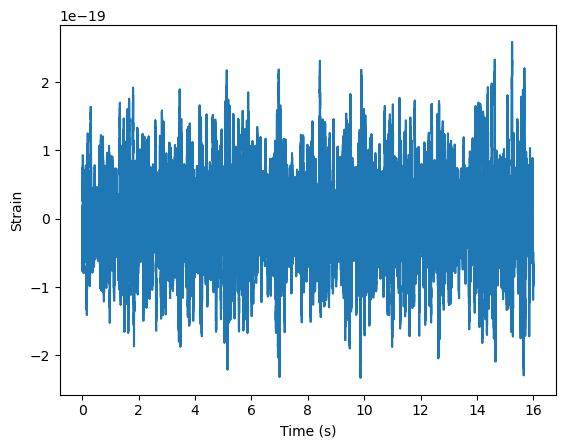

In [5]:
plt.figure()
plt.plot(time,data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.savefig('./figs/fig0.pdf')

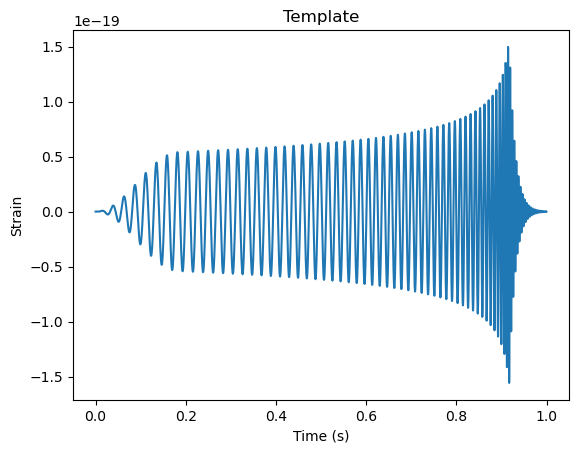

In [6]:
plt.plot(temp_time, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Template')

plt.savefig('./figs/fig1.pdf')

There are 3 methods detailed in the tutorial to find the signal: applying a bandpass filter, doing a time doman cross-correlation, and using an optimal matched filter. 

For the first one, we plot the Auto spectral discrete function (ASD) or the power spectral density function, of the signal.

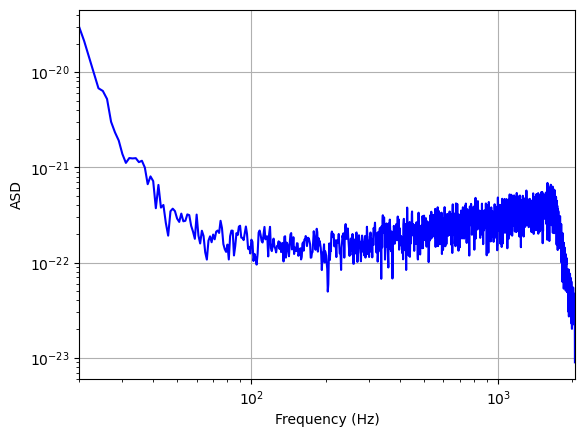

In [8]:
#------------------------
# Plot ASD of data
#-----------------------
plt.figure()
power_data, freq_psd = plt.psd(data[12*fs:], Fs=fs, NFFT=fs, visible=False)
plt.close()
plt.figure()
plt.loglog(freq_psd, np.sqrt(power_data), 'b')
plt.xlim([20, 2048])
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')

plt.savefig('figs/fig2.pdf')
plt.show()

Now we plot the ASD of the template. 

/tmp/ipykernel_690/931277166.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(freq, np.sqrt(power), 'r')


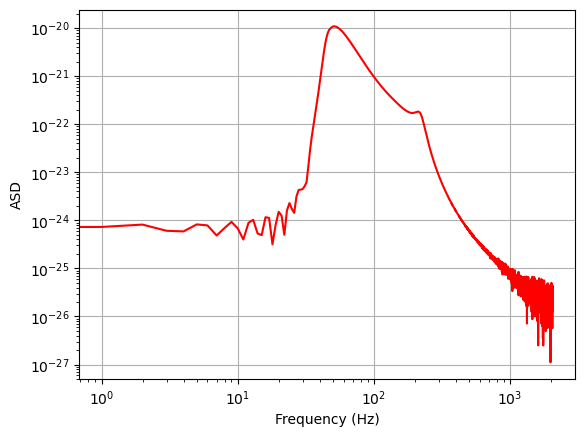

In [9]:
#----------------------
# Plot ASD of template
#----------------------
power, freq = plt.psd(template, Fs=fs, NFFT=fs, visible=False)
plt.loglog(freq, np.sqrt(power), 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')
plt.savefig('figs/fig3.pdf')
plt.show()

Finally, we apply a bandpass filter to the data

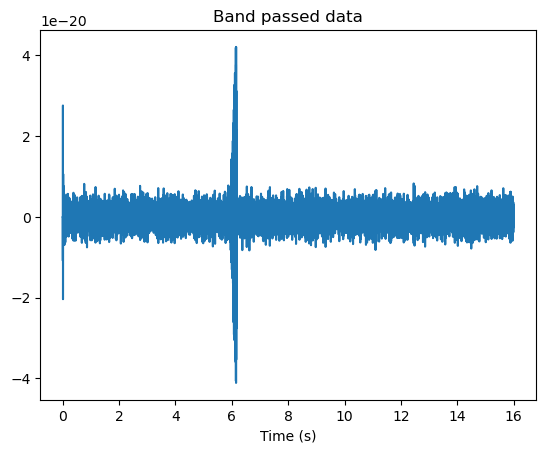

In [10]:
#-------------------------------------
# Apply a bandpass filter to the data
#------------------------------------
(B,A) = sig.butter(4, [80/(fs/2.0), 250/(fs/2.0)], btype='pass')
data_pass= sig.lfilter(B, A, data)
plt.figure()
plt.plot(time, data_pass)
plt.title('Band passed data')
plt.xlabel('Time (s)')
plt.savefig('figs/fig4.pdf')

We see that a very loud, peaked signal is visible at a bit greater than 6 seconds. 

For our next method, of time domain cross-correlation, we 